# Project Report - TD 4 - Topological Persistence


*by Joseph DE ROFFIGNAC and Ten NGUYEN HANAOKA* 

The purpose of this notebook is to address all the exercises from Lab Session 4 (INF556 – TD4), which focuses on implementing an algorithm to compute persistent homology with coefficients in the field ℤ/2ℤ (also denoted ℤ₂), and on testing it across various filtrations. This Jupyter Notebook basically contains all the answers of the questions, the code and our analysis of the problem.

Additionnally : 
* The folder <i>filtrations</i> contains all the filtrations of the TD in their .txt format
* the file <i>utils.py</i> contains some useful functions
* the folder <i>img</i> contains the diagram of triangulations we designed for some objects of the TD 

---
# Introduction

Let's start with some imports

In [1]:
%pip install tqdm
%pip install plotly

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import read_filtration, plot_barcodes


We import the <i>read_filtration</i> functions, which allow us to read the text files from the filtrations folder, as well as the <i>plot_barcodes</i> function to display the obtained barcodes.

We decided to replace the Simplex class with a lighter version using dicts. Thus, a simplex is just a dict with items : 
* val (float): the time of appearance in the filtration
* dim (int): the dimension of the simplex
* vert (set[int]): the set of vertex IDs (integers).

In addition, a <i>read_filtration</i> function in utils.py is available, which takes a filename (str) as input and returns a filtration represented as a list of simplices.


An example of how to use <i>read_filtration</i> is given just below (filtration_test is the initial filtration from the TD):

In [3]:
filtration = read_filtration("filtrations/filtration_test.txt")
for simplex in filtration:
    print(simplex)

{'time': 1.0, 'dim': 0, 'vert': {2}}
{'time': 1.0, 'dim': 0, 'vert': {4}}
{'time': 1.0, 'dim': 0, 'vert': {1}}
{'time': 2.0, 'dim': 1, 'vert': {2, 4}}
{'time': 2.0, 'dim': 1, 'vert': {1, 2}}
{'time': 3.0, 'dim': 0, 'vert': {7}}
{'time': 4.0, 'dim': 1, 'vert': {4, 7}}
{'time': 4.0, 'dim': 1, 'vert': {1, 7}}
{'time': 5.0, 'dim': 1, 'vert': {1, 4}}
{'time': 6.0, 'dim': 2, 'vert': {1, 4, 7}}


To simplify our process, we've added a line in <i>read_filtration</i>, that outputs a time sorted filtration.

---
# 1. Boundary matrix

**Question 1** : Compute the boundary matrix B of the filtration from the vector of simplices F. 

We opted for a sparse representation of the boundary matrix: a Python list of sets indexed by the columns of the matrix \(j\). Formally:  

$$
B[j] = \{\, i \in \{0, 1, \dots, m-1\} \;|\; b_{i,j} = 1 \,\}, \quad j \in \{0, 1, \dots, m-1\}
$$

where $(b_{i,j}) \in \mathcal{M}_m(\mathbb{Z}_2)$ is the boundary matrix.  

The advantages are as follows:  

- Memory complexity is linear in the number of 1s in $b$, which in practice is often $O(m)$ or $o(m^2)$.  
- Using Python sets allows efficient computation of symmetric differences between columns during the matrix reduction algorithm (see Q2).


In [4]:
def boundary_matrix(filtration: list[dict]) -> list[set[int]]:
    
    # Dictionnaire : clé = frozenset(vertices), valeur = index dans la filtration
    index_map = {frozenset(s["vert"]): i for i, s in enumerate(filtration)}

    n = len(filtration)
    boundary = [set() for _ in range(n)]

    for j, simplex in enumerate(filtration):
        verts = simplex["vert"]
        dim = simplex["dim"]

        # Génération des faces en retirant un sommet
        if dim > 0:
            for v in verts:
                face = frozenset(verts - {v})
                i = index_map.get(face)
                if i is not None:
                    boundary[j].add(i)

    return boundary

print(boundary_matrix(filtration))

[set(), set(), set(), {0, 1}, {0, 2}, set(), {1, 5}, {2, 5}, {1, 2}, {8, 6, 7}]


To create the boundary matrix, one could iterate over $i$ and $j$ from $1$ to $m$ and test whether $\sigma_i$ is a face of $\sigma_j$, but the complexity would be far too high with this naive algorithm: $\Omega(m^2)$.

However, given a simplex $\sigma_j = [v_0, \dots, v_r]$, there are actually very few simplices $\sigma_i$ that could be a face: they are simply

$$
[v_0, \dots, \hat{v_k}, \dots, v_r], \quad k = 0, \dots, r
$$

Consequently, it suffices to store the simplices and their indices in a dictionary

$$
\text{index\_map} = \{\text{vertices} \mapsto \text{index}\}
$$

(using the immutable type frozenset).  

For each simplex $\sigma_j$, we simply retrieve the indices $i$ of these faces (which are necessarily in the filtration since we are in a simplicial complex).

Regarding complexity:

- Line 4: creation of the index dictionary in $O(m)$  
- Line 9: traversal of the $m$ simplices  
    - For each simplex $\sigma$, the time complexity is $O(\dim(\sigma))$ (Line 15).  
      If the dimension of simplices is bounded (in practice in this assignment we do not exceed dimension 3), each simplex is processed in constant time.  
    - In the case where the dimensions $d$ of simplices can be arbitrarily large, note that a simplex of dimension $d$ has $2^d - 1$ faces. Hence, $d_{\max} = O(\log m)$.

**Conclusion:** The complexity of boundary_matrix is linear in this assignment (and quasi-linear in very few cases, e.g., for balls $\mathbb{B}_d$ and spheres $\mathbb{S}_d$).


---
# 2. Reduction algorithm

**Question 2**  : Implement the reduction algorithm for your representation of the boundary matrix. Evaluate its complexity.

We implement the classical Gaussian-elimination algorithm seen during the lecture.

In [5]:
def reduce_boundary_matrix(boundary : list[set[int]]) -> list[set[int]]:
    
    reduced_boundary = boundary.copy()
    m = len(reduced_boundary)

    pivots = {}

    for j in range(m):

        low_j = max(reduced_boundary[j]) if reduced_boundary[j] else -1
        while low_j != -1 and low_j in pivots:

            i = pivots[low_j]

            # Perform column addition (mod 2) : XOR
            reduced_boundary[j] = set(reduced_boundary[j]) ^ set(reduced_boundary[i])
            low_j = max(reduced_boundary[j]) if reduced_boundary[j] else -1
        if low_j != -1:
            pivots[low_j] = j

    return reduced_boundary


**Question 3** Reduce the complexity of the reduction to $O(m^3)$ in the worst case, and to $O(m)$ in cases where the matrix remains sparse throughout, where m is the number of simplices in the filtration. Argue that your code does have the desired worst-case and best-case complexities.

Let $m$ be the number of simplices (columns in the boundary matrix).

The algorithm iterates over each column of the boundary matrix. 
1) For each column, it repeatedly eliminates its pivot by XOR-ing with previously reduced columns until the column's pivot is unique.
2) Each column stores indices of nonzero entries (faces) as a set.

Let's first compute the worse-case complexity.
For each column $j$, let's denote $c_j$ the number of nonzero entries. Computing the pivot and performing a symmetric difference with another column takes each time $\mathcal{O}(c_k+c_i)$ where $c_i$ is the number of nonzero entries in column $i$ that we XOR-ed with.
In the worst-case, each column may be XOR-ed with all previous columns, and hence $\mathcal{O}(m)$ operations per column.
We are repeating this inner loop for all columns, so we get a total complexity of : 
$$\mathcal{O}(m)\cdot\mathcal{O}(m)\cdot\mathcal{O}(m) = \mathcal{O}(m^3)$$


Now if we consider the sparse matrix case : 
If the matrix remains sparse, for each of the $m$ columns, we check its pivot. Finding the pivot (the largest index) is $\mathcal{O}(1)$ since the column is small. 
Each column is XOR-ed with a previously reduced column only if there is a pivot conflict.  
We suppose that in a sparse matrix, the chance of pivot conflict is low, so typically only a constant number of XORs are needed per column. 
Each column costs $\mathcal{O}(1)$  for pivot detection and reduction. With $m$ columns, total operations: $\mathcal{O}(m).$ 

---

**Question 4** Write a function that outputs the barcode from the reduced boundary matrix in a file. The format must be the following one: 1 line per interval, containing 3 numbers: the dimension of the homological feature associated with the interval, the left endpoint of the interval (which is the filtration value associated with the simplex that created the homological feature), the right endpoint (which is the filtration value associated with the simplex that killed the homological feature), separated by white spaces. For instance, interval [b,d) in dimension k is written k b d.

For this part, we've implemented step by step the algorithm given in the end of lecture 4.

In [6]:
def extract_barcodes(reduced_boundary: list[set[int]], filtration: list[dict]) -> list[tuple[int, int, int]]:
    barcodes = []
    paired = set()

    for j, col in enumerate(reduced_boundary):
        if col:
            low_j = max(col)  # sorted list: last element = pivot 
            barcodes.append((filtration[low_j]["dim"], low_j, j))  # (dimension, birth, death)
            paired.add(low_j)
            paired.add(j)

    # Infinite bars: unpaired simplices
    for i, f in enumerate(filtration):
        if i not in paired:
            barcodes.append((f["dim"], i, -1))  # death = ∞

    # Sort by (dimension, birth index, death index)
    barcodes.sort(key=lambda x: (x[0], x[1], x[2] if x[2] != -1 else float('inf')))

    # Convert bars to (dimension, birth time, death time)
    barcodes = [(dim, filtration[birth_idx]["time"], filtration[death_idx]["time"] if death_idx != -1 else float('inf'))
                for dim, birth_idx, death_idx in barcodes]
    return barcodes


Let $m$ be the number of simplices in the filtration.

Each column contains pivot indices. Computing the maximum of a column col takes $O(|\text{col}|)$ time. Summing over all $m$ columns, the total cost is  

   $$
   \sum_{j=0}^{m-1} O(|\text{col}_j|) = O\Big(\sum_{j=0}^{m-1} |\text{col}_j|\Big)
   $$

In a sparse matrix, most columns are small, so $\sum |\text{col}_j| = O(m)$. In the worst case (dense columns), $\sum |\text{col}_j| = O(m^2)$.  

Checking membership in a set takes $O(1)$ on average, and there are $m$ simplices. Hence this step is $O(m)$.

There are at most $m$ barcodes. Sorting by (dimension, birth, death)
costs  

   $$
   O(m \log m)
   $$

Iterating over $m$ barcodes and replacing indices by times costs $O(m)$.

**Worst-case:** $O(m^2 + m \log m) = O(m^2)$ (if columns of the reduced matrix are dense).  
**Best-case (sparse matrix):** $O(m \log m)$ (most columns are small).

Let $k_j$ be the size of column $j$ in the reduced boundary matrix. Then the cost of computing pivots is  
$$
\sum_{j=0}^{m-1} O(k_j)
$$
- In a sparse matrix, $\sum k_j = O(m)$, giving $O(m)$ total.  
- In the worst case, $\sum k_j = O(m^2)$.  

Sorting dominates only in the sparse case, giving $O(m \log m)$.  
Processing unpaired simplices and converting indices to times are $O(m)$.  

Hence, the function scales linearly with $m$ for sparse matrices and quadratically in the worst case.


In [7]:
def print_barcodes(barcodes: list[tuple[int, int, int]]) -> None:
    for dim, birth, death in barcodes:
        print(f"Dimension: {dim}, Birth: {birth}, Death: {death}")

---
# 3. Experiments

The function <i>process_filtration</i> is provided to perform all the aforementioned computations, thereby making the report more concise and easier to interpret.

In [ ]:
def process_filtration(filtration: list[dict], log_scale = False, minimum_length = 0.05, name: str) -> float:
    # Returns the time in seconds taken to process the filtration
    start_time = time.time()
    B = boundary_matrix(filtration)
    print("Boundary matrix computed.")
    barcodes = extract_barcodes(reduce_boundary_matrix(B), filtration)
    print("Barcodes extracted.")
    end_time = time.time()
    plot_barcodes(barcodes, name=name, minimum_length=minimum_length, log_scale = log_scale)
    return end_time - start_time

## 3.1. Classical spaces

**Question 5/6** : Compute triangulations and barcodes for some classical topological spaces

In all the filtrations we consider, the filtration value of each simplex is equal to its dimension.  
It is clear that this defines a valid topological order on the filtration.  
For example, vertices are inserted at time $0.0$, edges at time $1.0$, and so on.  

This improves the readability of the barcodes since, in practice, there will be very few distinct timestamps and therefore few distinct bars.  

Consequently, we only need to define the triangulation of the studied objects.

### $\mathbb{B}_d$ and $\mathbb{S}_d$

For balls and spheres in dimension $d$, the filtration is quite straightforward:  

* ⁠For a $d$-dimensional ball, we consider the vertices $0, \dots, d$, and define  
  $K := \mathcal{P}(\llbracket 0, d \rrbracket) \setminus \{\emptyset\}$,  
  the set of all non-empty subsets of $\llbracket 0, d \rrbracket$.  

* ⁠For a $d$-dimensional sphere, we take the filtration of $\mathbb{B}_{d+1}$  
  from which we remove the simplex of dimension $d+1$.

Boundary matrix computed.
Barcodes extracted.


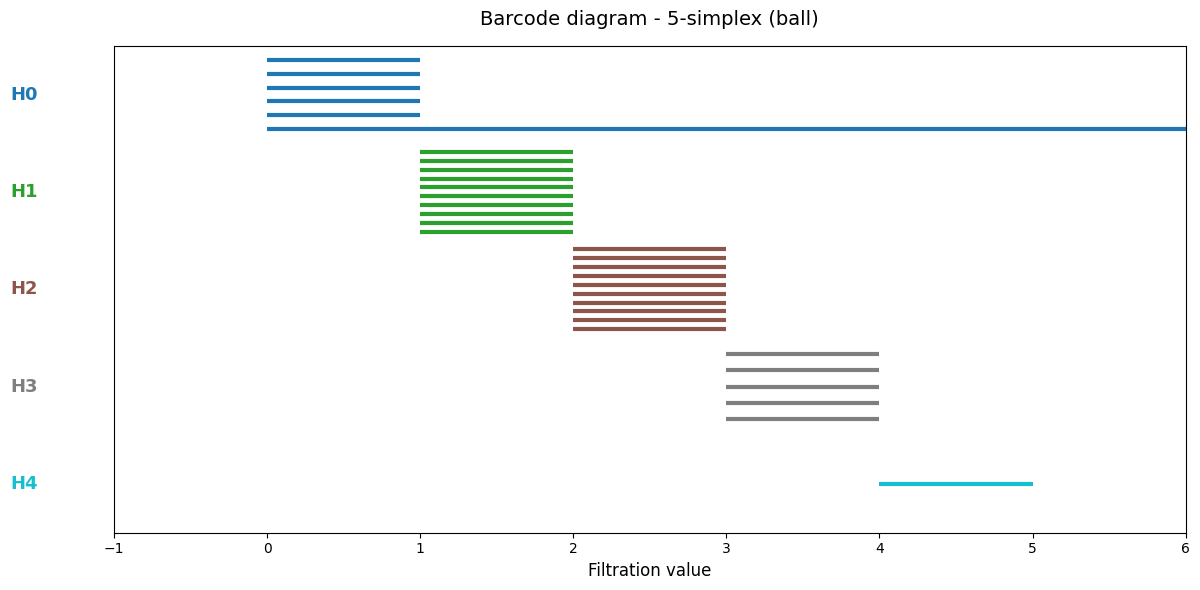

Boundary matrix computed.
Barcodes extracted.


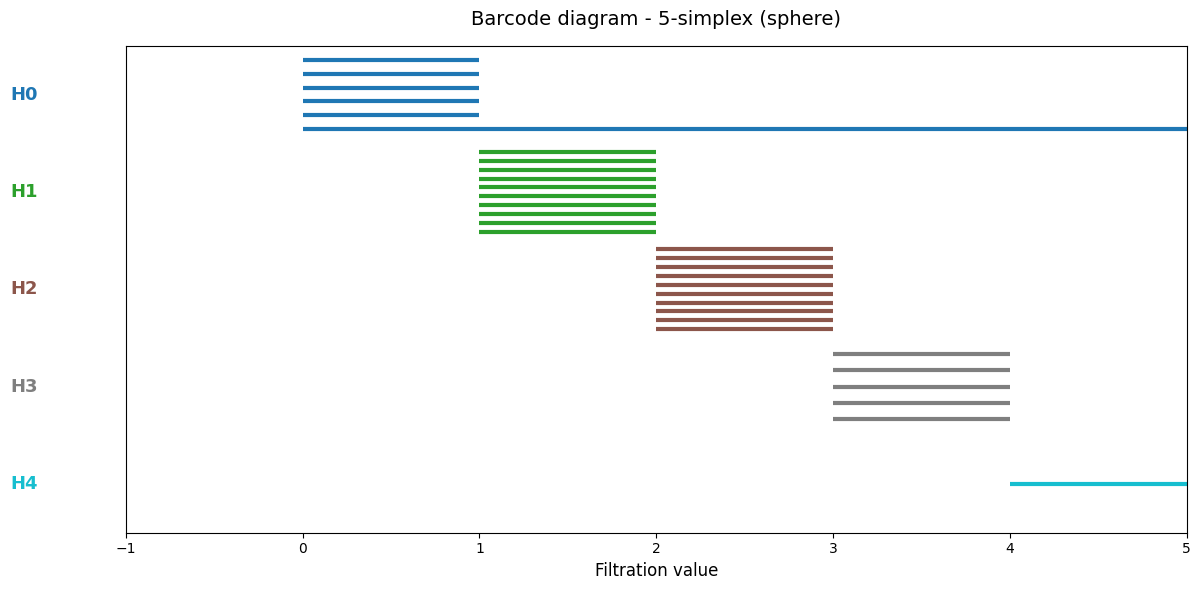

0.00017690658569335938

In [9]:
from itertools import combinations

def create_filtration(shape = "ball", dim = 10):
    # énumérer les parties d'une liste de points
    if shape == "ball":
        points = list(range(dim + 1))
    elif shape == "sphere":
        points = list(range(dim + 2))
    else:
        raise Exception("Shape should be \"ball\" or \"sphere\"")

    filtration = []
    for r in range(dim+1):
        for comb in combinations(points, r+1):
            filtration.append({"vert": set(comb), "dim": r, "time": r})

    return filtration

process_filtration(create_filtration("ball", 5), name="5-simplex (ball)")
process_filtration(create_filtration("sphere", 4), name="5-simplex (sphere)")

We recover the result from the lecture and exercises:  

For the ball $B_d$, we have $\beta_0 = 1$ and $\beta_r = 0$ for $r \geqslant 1$.  
For the sphere $S_d$, we have $\beta_0 = \beta_d = 1$ and $\beta_r = 0$ otherwise.  

Note that the bars in the barcode are organized into blocks of bars $[d, d+1)$,  
to which we add the infinite bars $[d, +\infty)$. This is because the only simplices that can create or destroy a bar in dimension $d$  
appear at time $d + 1$.

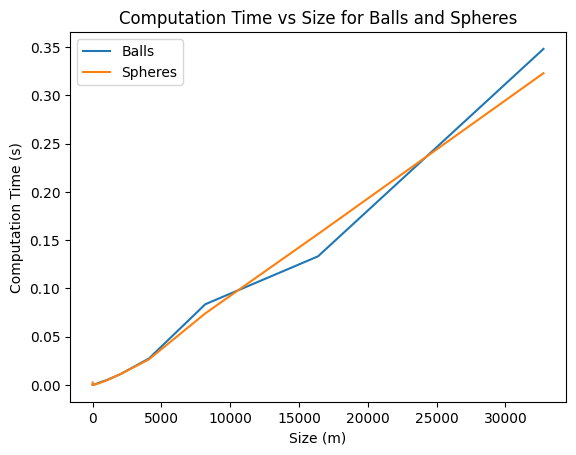

In [10]:
# Tracé le temps de calcul en fonction de la dimension pour les deux types de filtrations
max_dim = 15

ball_sizes = [2**(d+1) - 1 for d in range(0, max_dim)]
sphere_sizes = [2**(d+2) - 2 for d in range(0, max_dim-1)]
ball_times = []
sphere_times = []
for dim in range(0, max_dim):
    start_time = time.time()
    _ = reduce_boundary_matrix(boundary_matrix(create_filtration("ball", dim)))
    ball_time = time.time() - start_time
    ball_times.append(ball_time)
for dim in range(0, max_dim-1):
    start_time = time.time()
    _ = reduce_boundary_matrix(boundary_matrix(create_filtration("sphere", dim)))
    sphere_time = time.time() - start_time
    sphere_times.append(sphere_time)

plt.plot(ball_sizes, ball_times, label="Balls")
plt.plot(sphere_sizes, sphere_times, label="Spheres")
plt.xlabel("Size (m)")
plt.ylabel("Computation Time (s)")
plt.title("Computation Time vs Size for Balls and Spheres")
plt.legend()
plt.show()

We observe that the computation time for spheres and balls is practically linear with respect to the size of the filtration.  
This corroborates the result from Question 3. Note that the matrix contains $O(m)$ non-zero elements in the case of balls (and also spheres).  

Indeed, for a ball of dimension $d$ and for $k \in \{1, \dots, d\}$,  
the filtration contains $\binom{d+1}{k+1}$ simplices of dimension $k$,  
and each simplex of dimension $k$ has $k+1$ faces of dimension $k-1$.  

Thus, the total number of non-zero elements in the boundary matrix is:  

$$
\sum_{k=1}^{d} (k+1) \binom{d+1}{k+1} = (d+2) 2^{d} - (d+1) = O(m)
$$

---
### Moebius band

<p align="center">
    <img src="img/triangulation_moebius_band.png" alt="Moebius band triangulation" width="300", center />
</p>

We can use a triangulation similar to that of the cylinder, using 6 vertices, 12 edges, and 6 triangles, as shown above.

Boundary matrix computed.
Barcodes extracted.


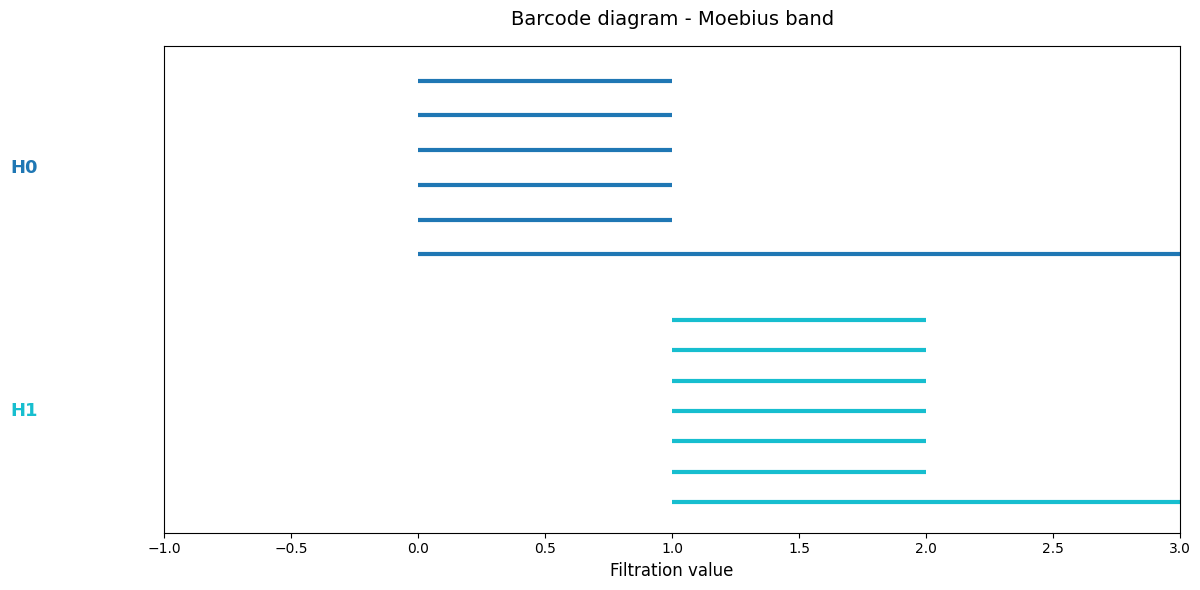

0.0002598762512207031

In [11]:
filtration = read_filtration("filtrations/filtration_moebius.txt")
process_filtration(filtration, name="Moebius band")

---
### Torus

<p align="center">
    <img src="img/triangulation_torus.png" alt="Torus triangulation" width="300", center />
</p>

The triangulation used is similar to the one seen during the exercises.  
Because of the gluing of the top and bottom edges, we are forced to add 3 new vertices.  
We now have 9 vertices, 27 edges, and 18 triangles.

Boundary matrix computed.
Barcodes extracted.


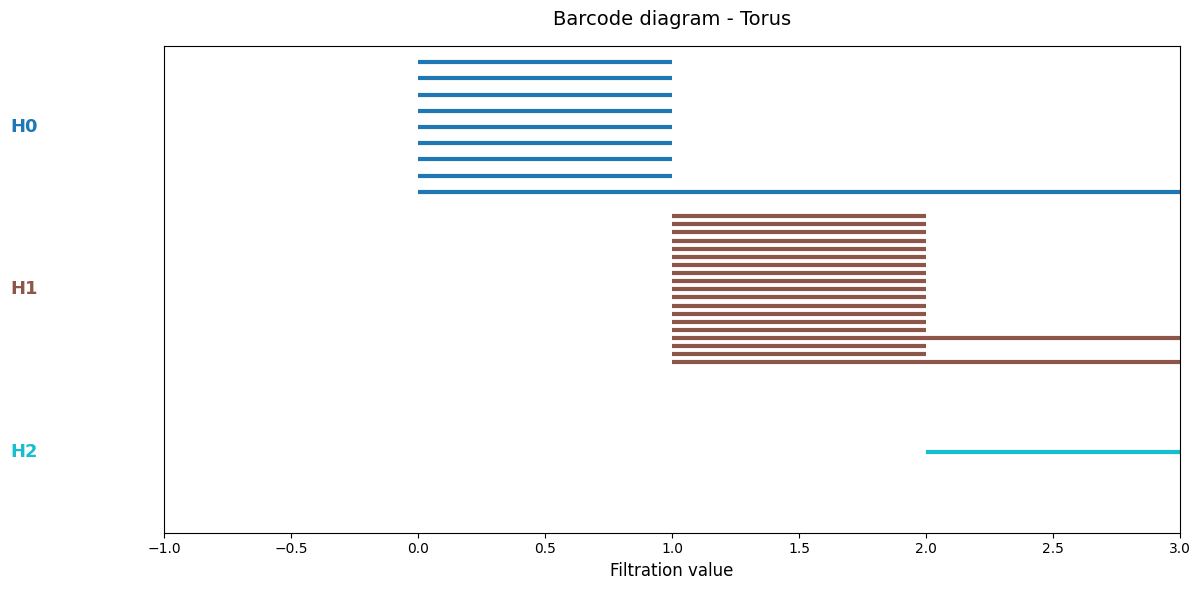

0.00028586387634277344

In [12]:
filtration = read_filtration("filtrations/filtration_torus.txt")
process_filtration(filtration, name="Torus")

---
### Klein bottle

<p align="center">
    <img src="img/triangulation_klein_bottle.png" alt="Klein bottle triangulation" width="300", center />
</p>

We use the same triangulation as for the torus, but we invert the representation of vertices 3 and 4 on the right edge.

Boundary matrix computed.
Barcodes extracted.


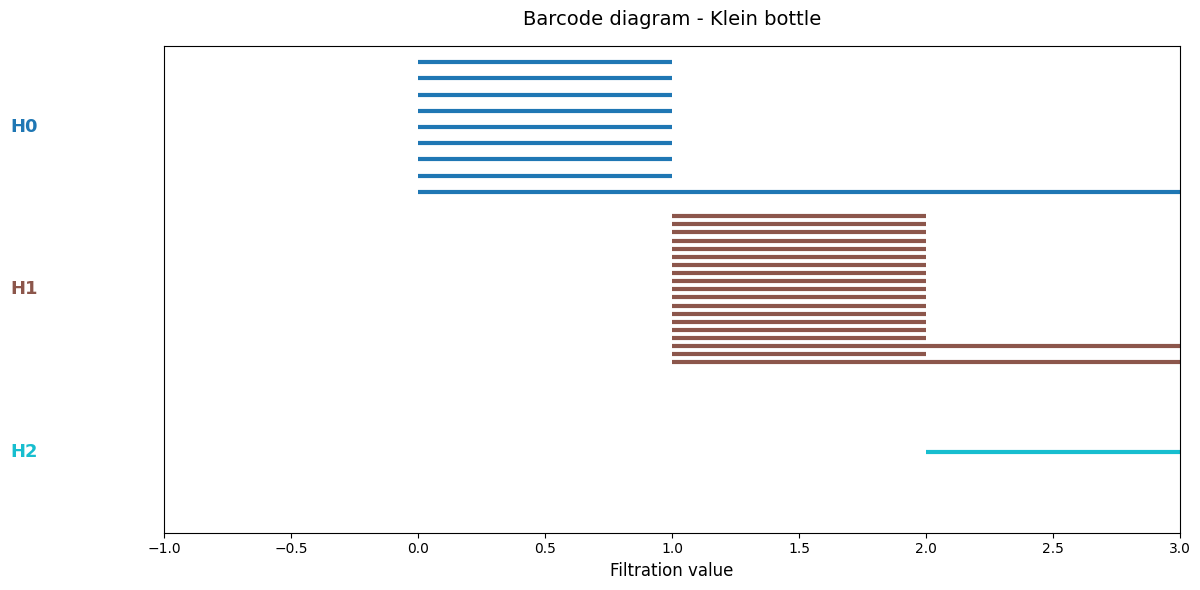

In [13]:
filtration = read_filtration("filtrations/filtration_klein_bottle.txt")
_ = process_filtration(filtration, name="Klein bottle")

---
### Projective plane $\mathbb{RP}^2$

<p align="center">
    <img src="img/triangulation_projective_plane.png" alt="Projective plane triangulation" width="300", center />
</p>

For the projective plane, we are forced to add a tenth vertice (9), and to change the directions of some edges to prevent the diagram from having 2 times the same triangles.

Boundary matrix computed.
Barcodes extracted.


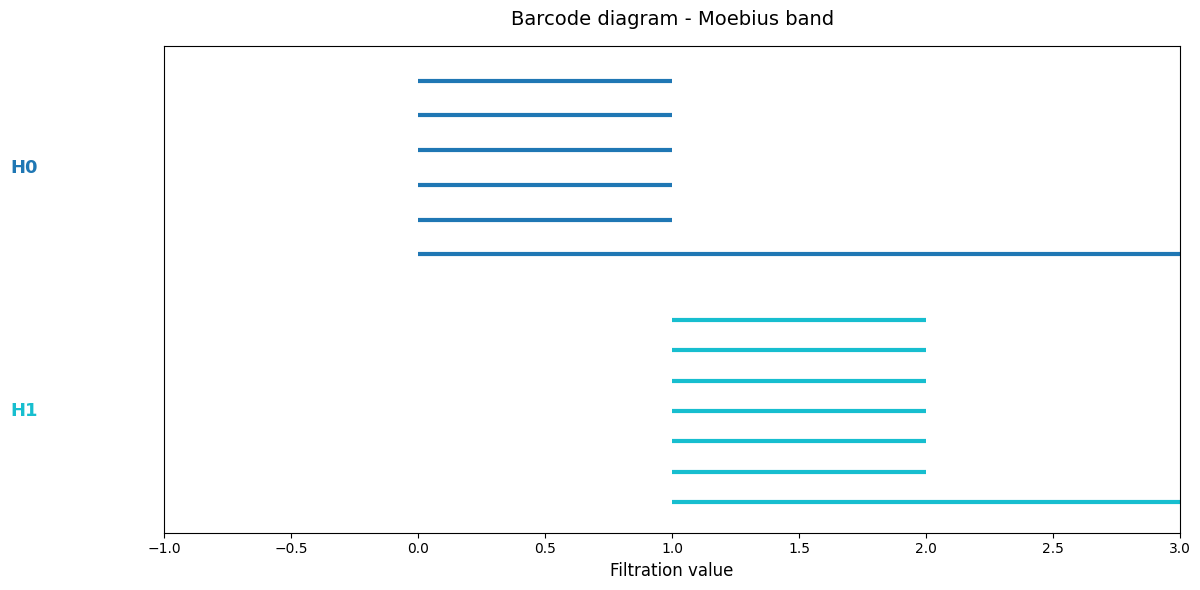

In [14]:
filtration = read_filtration("filtrations/filtration_moebius.txt")
_ = process_filtration(filtration, name="Moebius band")

---
## 3.2. Simulated data

### Filtration A

Boundary matrix computed.
Barcodes extracted.


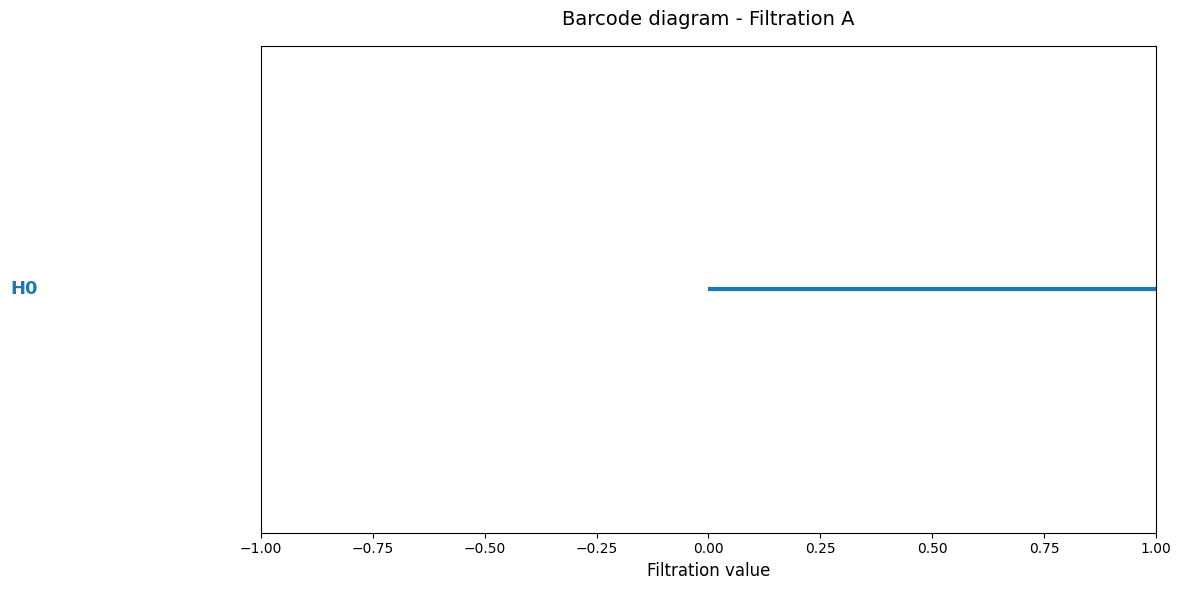

Size of filtration A: 428643
Time to process filtration A: 108.42401909828186 seconds


In [ ]:
filtration_a = read_filtration("filtrations/filtration_A.txt")
duration = process_filtration(filtration_a, name="Filtration A", log_scale=True, minimum_length=0.0)
print("Size of filtration A:", len(filtration_a))
print("Time to process filtration A:", duration, "seconds")

**Size of filtration A:** 428643  
**Time to process filtration A:** 108.7078 seconds (may vary depending on the execution)

Analysis of the underlying topological object
- From the barcode diagram, we measure  
  $\beta_0 = 1, \quad \beta_1 = 0, \quad \beta_2 = 0, \ldots$
  Thus, the corresponding topological object is **connected**, with **no holes or cavities**.  
  All connected components of this object are **homotopic to a point**.

- We can also study the **dynamic construction** of the filtration.  
  At the beginning, all vertices are generated individually (this is when most of the $H_0$ bars are born).  
  Then, edges are progressively added, which eliminates many connected components (points merge and $H_0$ bars die).  
  Finally, a few triangles (2D simplices) remove all the remaining 1-cycles without creating any cavity.


### Filtration B

Boundary matrix computed.
Barcodes extracted.


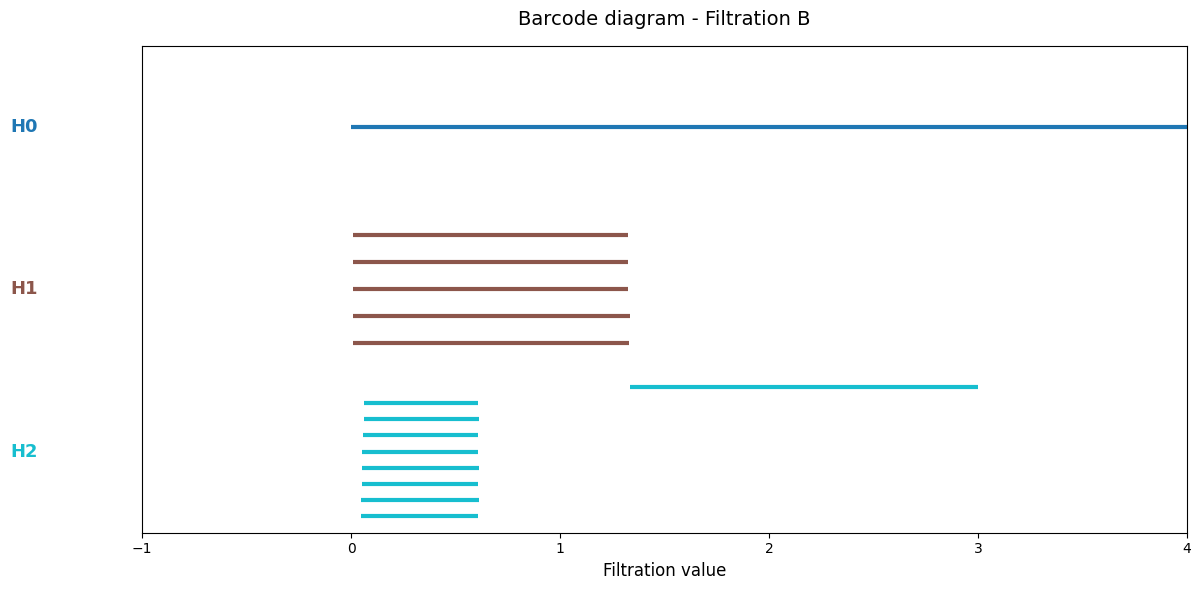

Size of filtration B: 108161
Time to process filtration B: 5.465867757797241 seconds


In [ ]:
filtration_b = read_filtration("filtrations/filtration_B.txt")
duration = process_filtration(filtration_b, name="Filtration B", log_scale = False, minimum_length=0.05)
print("Size of filtration B:", len(filtration_b))
print("Time to process filtration B:", duration, "seconds")

**Size of filtration B:** 108161  
**Time to process filtration B:** 5.4838478565216064 seconds  


Analysis of the underlying topological object
- The Betti numbers are the same as for filtration A.  
  Therefore, we have the same analysis as for object A.
- In filtration B, the vertices are added first, followed very quickly by the edges that connect them  
  (since all $H_0$ bars were very short except for the single infinite one).  
  Then, some **cavities** and **1-cycles** appear through the addition of triangles and edges.  
  The cavities are destroyed by the addition of **3D simplices**, and the cycles disappear  
  when new triangles are added around $t = 1.3$ on the logarithmic scale.  
  Apparently, these last added triangles create a **central cavity**  
  (corresponding to the large $H_2$ bar).

**Conclusion:** The evolution of filtration B follows a similar pattern to A,  
but exhibits a transient formation of higher-dimensional structures before stabilization.


### Filtration C

Boundary matrix computed.
Barcodes extracted.


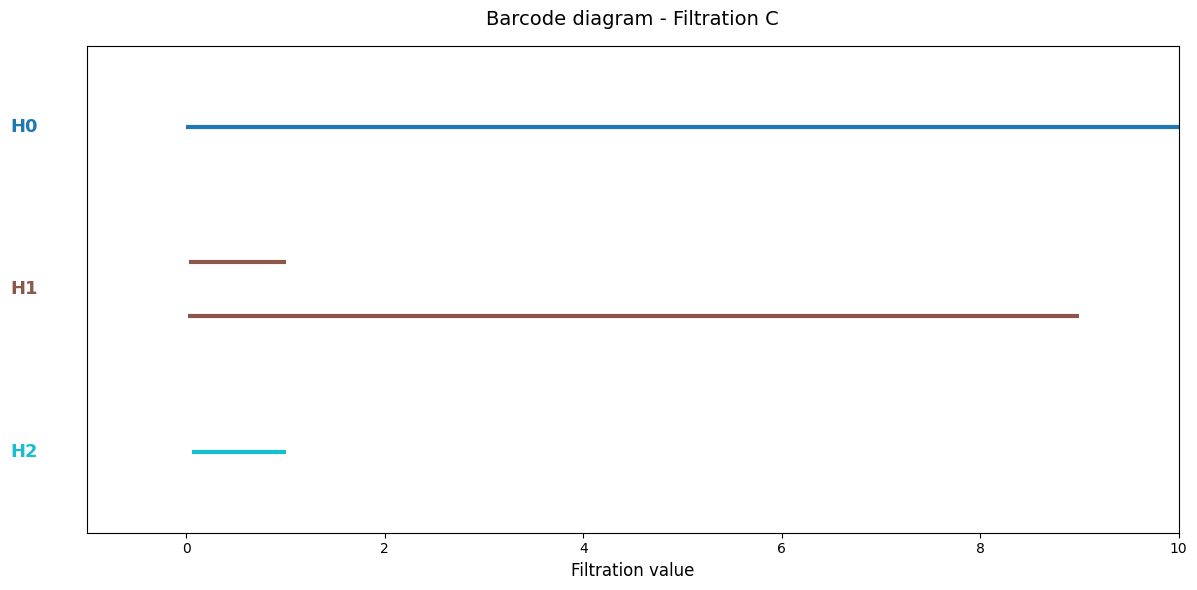

Size of filtration C: 180347
Time to process filtration C: 14.846550703048706 seconds


In [ ]:
filtration_c = read_filtration("filtrations/filtration_C.txt")
duration = process_filtration(filtration_c, name="Filtration C", log_scale = False, minimum_length = 0.0)
print("Size of filtration C:", len(filtration_c))
print("Time to process filtration C:", duration, "seconds")

**Size of filtration C:** 180347  
**Time to process filtration C:** 14.717528820037842 seconds  


Analysis of the underlying topological object
- Once again, the Betti numbers are the same as for filtrations A and B.  
  Therefore, we obtain the same topological interpretation as for those objects.
  
- In filtration C, the vertices are added almost simultaneously with many edges and triangles.  
  As a result, the complex becomes **connected very quickly** (an edge is added for each new vertex),  
  with **few 1-cycles** remaining (since triangles are added to fill them).  
  
  A very large **cycle** persists for a long time.Starting from $t = 1$, a **filling phase** begins:  
  the main cavity is divided into several smaller cavities,  
  which are then rapidly filled by the addition of **3D simplices**.

**Conclusion:**  
Filtration C shows a faster and denser connection process,  
leading to an early stabilization of the complex and a brief persistence of a large cavity before it is filled.


### Filtration D

In [ ]:
filtration_d = read_filtration("filtrations/filtration_D.txt")
duration = process_filtration(filtration_d, name="Filtration D", log_scale = True, minimum_length = 0.0)
print("Size of filtration D:", len(filtration_d))
print("Time to process filtration D:", duration, "seconds")

Boundary matrix computed.


**Size of filtration D:** 2716431  
**Time to process filtration D:** 586.8552062511444 seconds  

Analysis of the underlying topological object
- Once again, the Betti numbers are the same as for the previous filtrations.  
  Therefore, we obtain the same topological interpretation as for those objects.
  
- In filtration D, the construction order occurs through small **clusters** or **balls**.  
  These clusters are built rather independently and are then merged together  
  (similarly to what happens in filtration A).  
  It is at this stage that the $H_0$ bars disappear.
  
  Around $t \in [-7, -5]$ on the logarithmic scale,  
  the initial 1-cycle is divided into many smaller 1-cycles as new edges are added.  
  These cycles are gradually eliminated by the addition of triangles that fill the corresponding surfaces.  
  
  At $t = 0$, the same phenomenon occurs one dimension higher and in a more instantaneous manner.  
  The large cavity is subdivided by the addition of triangles,  
  which are then very efficiently filled by the addition of the final **3D simplices**.

**Conclusion:**  
Filtration D exhibits a hierarchical construction process through independent local clusters  
that later merge, leading to the gradual disappearance of low-dimensional features  
and a rapid filling of higher-dimensional cavities near the end of the filtration.

---
## Final analysis

Finally, obtaining the barcodes provides valuable insight into the topology  
of the partial simplicial complexes throughout time and at the end of the process.  
They also help us understand the order in which the simplices are added:

- **By increasing dimension** (filtration A)
- **By vertex order** — a vertex is added and then connected by adding all simplices containing it (filtrations B and C)  
- **By clusters or local groups** — some clusters are completed and later connected together (filtration D)

However, the algorithm does not allow us to extract more **geometric information**  
about the structure of the data, since the Betti numbers — even when considered over time —  
do not fully characterize a geometric or topological object.

<table>
  <thead>
    <tr>
      <th style="text-align:left;">Filtration</th>
      <th style="text-align:right;">Size</th>
      <th style="text-align:right;">Time (s)</th>
      <th style="text-align:right;">Time / Size (s / élément)</th>
    </tr>
  </thead>
  <tbody>
    <tr><td>A</td><td style="text-align:right;">428 643</td><td style="text-align:right;">108.7078</td><td style="text-align:right;">0.0002536</td></tr>
    <tr><td>B</td><td style="text-align:right;">108 161</td><td style="text-align:right;">5.4838</td><td style="text-align:right;">0.0000507</td></tr>
    <tr><td>C</td><td style="text-align:right;">180 347</td><td style="text-align:right;">14.7175</td><td style="text-align:right;">0.0000816</td></tr>
    <tr><td>D</td><td style="text-align:right;">2 716 431</td><td style="text-align:right;">444.8562</td><td style="text-align:right;">0.0001638</td></tr>
  </tbody>
</table>